Problem Statement : Our company is running online ad campaigns and wants to determine whether a new campaign (Test group) performs better than the current campaign (Control group). The key metric we are evaluating is the conversion rate (purchases per website click). The experiment ran for three months, targeting users aged 18-45 who have engaged with our website in the past six months. If the new campaign leads to a statistically significant increase in conversions (p-value < 0.05), we may consider rolling it out to all users.

HYPOTHESES

Null Hypothesis (H₀): There is no significant difference or the Test group does not have a higher conversion rate than the Control group. Any observed difference is due to random chance.

Alternative Hypothesis (H₁): The Test group has a significantly higher conversion rate than the Control group.

In [1]:
# importing libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the dataset
data = pd.read_csv("ab_test_data.csv")
print("Data Shape:", data.shape)
data.head()

Data Shape: (10000, 10)


,campaign_name,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchases
0,Test,2024-05-26,423.42,11870,14705,361,40,181,42,42
1,Control,2024-06-22,276.17,11654,7138,561,424,70,28,28
2,Control,2024-04-18,280.75,17439,39680,116,136,193,8,5
3,Control,2024-05-24,175.40,44103,28144,515,128,12,14,14
4,Control,2024-05-31,589.46,21238,28532,73,66,86,45,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   campaign_name   10000 non-null  object 
 1   date            10000 non-null  object 
 2   spend_usd       10000 non-null  float64
 3   impressions     10000 non-null  int64  
 4   reach           10000 non-null  int64  
 5   website_clicks  10000 non-null  int64  
 6   searches        10000 non-null  int64  
 7   view_content    10000 non-null  int64  
 8   add_to_cart     10000 non-null  int64  
 9   purchases       10000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


In [4]:
#Converting the date column to dateteime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   campaign_name   10000 non-null  object        
 1   date            10000 non-null  datetime64[ns]
 2   spend_usd       10000 non-null  float64       
 3   impressions     10000 non-null  int64         
 4   reach           10000 non-null  int64         
 5   website_clicks  10000 non-null  int64         
 6   searches        10000 non-null  int64         
 7   view_content    10000 non-null  int64         
 8   add_to_cart     10000 non-null  int64         
 9   purchases       10000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 781.4+ KB


In [6]:
# Checking for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [7]:
#Checking for null values
data.isnull().sum()

campaign_name     0
date              0
spend_usd         0
impressions       0
reach             0
website_clicks    0
searches          0
view_content      0
add_to_cart       0
purchases         0
dtype: int64

In [8]:
#Checking for unique values
for column in data:
    unique_values = np.unique(data[column].astype(str))  
    number_values = len(unique_values)  
    
    if number_values < 10:  
        print(f'Feature: {column} | Unique Values ({number_values}): {unique_values}')
    else:  
        print(f'Feature: {column} | Unique Values: {number_values} (Too many to display)')


Feature: campaign_name | Unique Values (2): ['Control' 'Test']
Feature: date | Unique Values: 91 (Too many to display)
Feature: spend_usd | Unique Values: 9141 (Too many to display)
Feature: impressions | Unique Values: 8926 (Too many to display)
Feature: reach | Unique Values: 8786 (Too many to display)
Feature: website_clicks | Unique Values: 750 (Too many to display)
Feature: searches | Unique Values: 490 (Too many to display)
Feature: view_content | Unique Values: 395 (Too many to display)
Feature: add_to_cart | Unique Values: 50 (Too many to display)
Feature: purchases | Unique Values: 55 (Too many to display)


In [9]:
data.describe()

,date,spend_usd,impressions,reach,website_clicks,searches,view_content,add_to_cart,purchases
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2024-05-15 04:05:39.840000256,337.030327,27351.608200,21479.363400,423.183800,253.526100,200.731800,24.475400,25.910200
min,2024-04-01 00:00:00,80.020000,5005.000000,3004.000000,50.000000,10.000000,5.000000,0.000000,0.000000
25%,2024-04-22 00:00:00,208.655000,16041.250000,12341.750000,241.000000,130.000000,101.000000,12.000000,13.000000
50%,2024-05-15 00:00:00,333.330000,27179.000000,21489.000000,421.000000,254.000000,200.000000,25.000000,26.000000
75%,2024-06-06 00:00:00,465.840000,38544.750000,30733.250000,609.250000,375.000000,301.000000,37.000000,39.000000
max,2024-06-30 00:00:00,599.950000,49996.000000,39994.000000,799.000000,499.000000,399.000000,49.000000,54.000000
std,NaN,149.788044,12920.126496,10642.384993,214.589726,141.803492,115.143244,14.346302,15.076149


In [10]:
#Checking for the proportions in each test group
data['campaign_name'].value_counts(normalize=True)  

campaign_name
Test       0.5
Control    0.5
Name: proportion, dtype: float64

In [11]:
#Checking the amount spend in each campaign group
data.groupby("campaign_name")["spend_usd"].sum()

campaign_name
Control    1675128.21
Test       1695175.06
Name: spend_usd, dtype: float64

In [12]:
#Checking the conversion rate, total purchases, total clicks by campaign group
conversion_rates = data.groupby("campaign_name").agg(
    total_clicks=("website_clicks", "sum"),
    total_purchases=("purchases", "sum")
)
conversion_rates["conversion_rate"] = conversion_rates["total_purchases"] / conversion_rates["total_clicks"]
print(conversion_rates)


               total_clicks  total_purchases  conversion_rate
campaign_name                                                
Control             2122695           122165         0.057552
Test                2109143           136937         0.064925


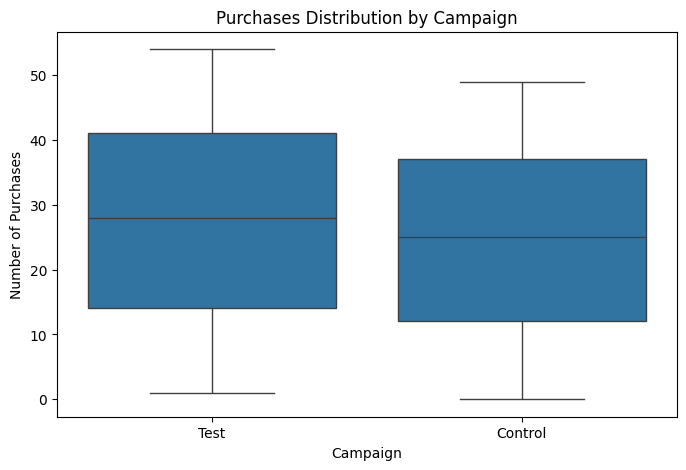

In [13]:
#box plot for the purchases
plt.figure(figsize=(8, 5))
sns.boxplot(x="campaign_name", y="purchases", data=data)
plt.title("Purchases Distribution by Campaign")
plt.xlabel("Campaign")
plt.ylabel("Number of Purchases")
plt.show()


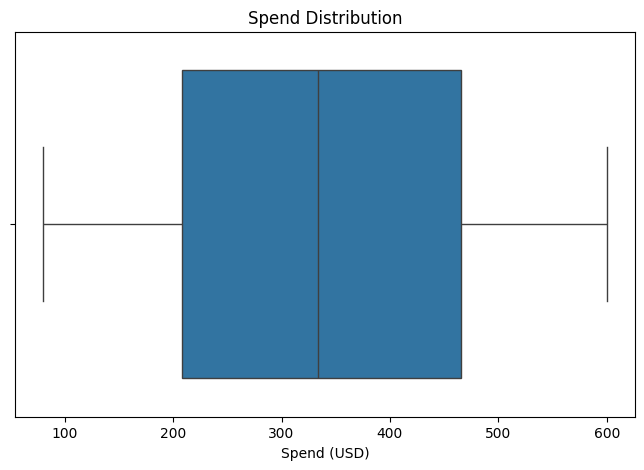

In [14]:
#Checking for outliers in the amount spent
plt.figure(figsize=(8,5))
sns.boxplot(x = data['spend_usd'])
plt.title('Spend Distribution')
plt.xlabel('Spend (USD)')
plt.show()

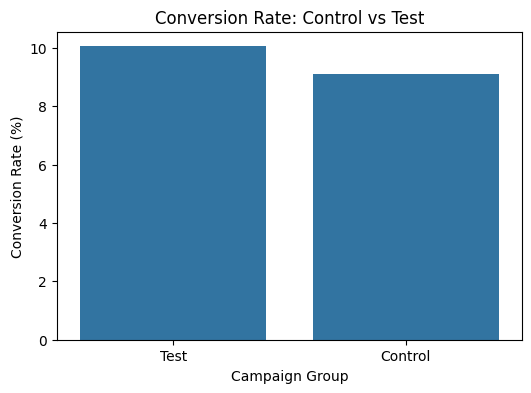

In [15]:
# Checking the conversion rate in within each campaign group
data['conversion_rate'] = (data['purchases'] / data['website_clicks']) * 100
plt.figure(figsize=(6,4))
sns.barplot(x='campaign_name', y='conversion_rate', data=data, ci=None)
plt.title('Conversion Rate: Control vs Test')
plt.xlabel('Campaign Group')
plt.ylabel('Conversion Rate (%)')
plt.show()


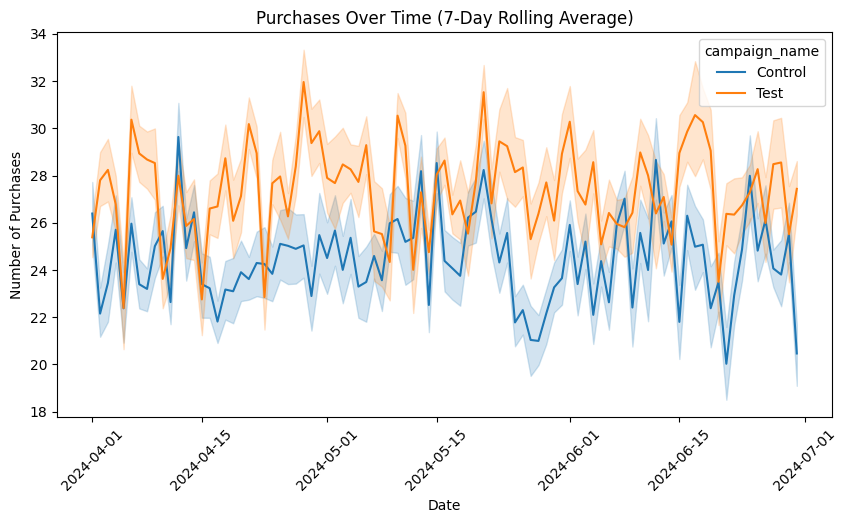

In [16]:
# Create a temporary DataFrame for visualization
temp_data = data.copy()
# sort the data by date
temp_data = temp_data.sort_values('date')

# Apply 7-day rolling average within each campaign group
temp_data['rolling_purchases'] = temp_data.groupby('campaign_name')['purchases'].transform(lambda x: x.rolling(7).mean())
plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='rolling_purchases', hue='campaign_name', data=temp_data)
plt.title('Purchases Over Time (7-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.show()



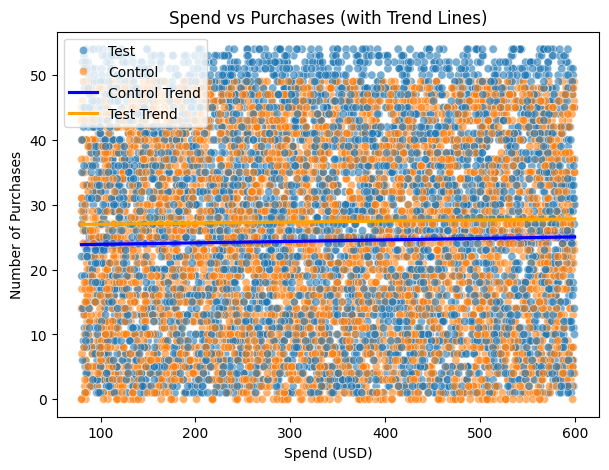

In [17]:
#Plotting a scattter plot for purchases and spend amount
plt.figure(figsize=(7,5))

# Scatter plot with transparency
sns.scatterplot(x='spend_usd', y='purchases', hue='campaign_name', data=data, alpha=0.6)

# Add regression lines separately for each campaign
sns.regplot(x='spend_usd', y='purchases', data=data[data['campaign_name'] == 'Control'], scatter=False, color='blue', label='Control Trend')
sns.regplot(x='spend_usd', y='purchases', data=data[data['campaign_name'] == 'Test'], scatter=False, color='orange', label='Test Trend')

plt.title('Spend vs Purchases (with Trend Lines)')
plt.xlabel('Spend (USD)')
plt.ylabel('Number of Purchases')
plt.legend()
plt.show()


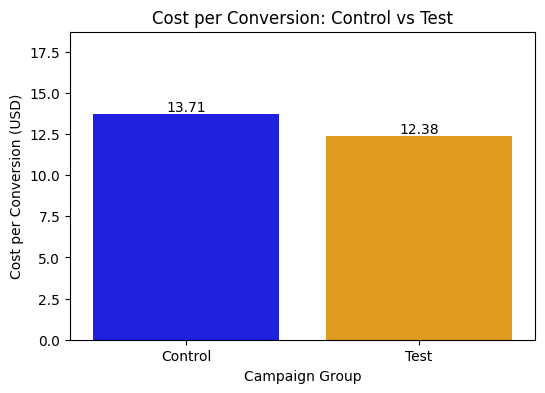

In [18]:
#Plotting the cost_per_conversion for each campaign group
cost_per_conversion = data.groupby('campaign_name').apply(lambda x: x['spend_usd'].sum() / x['purchases'].sum())
plt.figure(figsize=(6,4))
ax = sns.barplot(x=cost_per_conversion.index, y=cost_per_conversion.values, palette=['blue', 'orange'])

plt.title('Cost per Conversion: Control vs Test')
plt.xlabel('Campaign Group')
plt.ylabel('Cost per Conversion (USD)')
plt.ylim(0, max(cost_per_conversion.values) + 5)

# Annotate bars with values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


In [19]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test on conversion rates for each group
control_conversion_rate = data[data['campaign_name'] == 'Control']['conversion_rate']
test_conversion_rate = data[data['campaign_name'] == 'Test']['conversion_rate']

stat_control, p_control = shapiro(control_conversion_rate)
stat_test, p_test = shapiro(test_conversion_rate)

# Print p-values
print(f'Control Group: p-value = {p_control:.10e}')
print(f'Test Group: p-value = {p_test:.10e}')

# Interpretation
if p_control > 0.05 and p_test > 0.05:
    print("Both groups follow a normal distribution (Fail to reject H₀).")
else:
    print("At least one group is not normally distributed (Reject H₀).")


Control Group: p-value = 0.0000000000e+00
Test Group: p-value = 0.0000000000e+00
At least one group is not normally distributed (Reject H₀).


In [20]:
#Running the Z test
total_purchases = data.groupby("campaign_name")["purchases"].sum()
total_clicks = data.groupby("campaign_name")["website_clicks"].sum()

# Define purchases (successes) and total website clicks (trials)
purchases_test = total_purchases["Test"]
purchases_control = total_purchases["Control"]

clicks_test = total_clicks["Test"]
clicks_control = total_clicks["Control"]

# Store values in lists for Z-test
successes = [purchases_test, purchases_control]
trials = [clicks_test, clicks_control]

# Perform the one-tailed Z-test
z_stat, p_value = proportions_ztest(successes, trials, alternative='larger')

# Print results
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.10e}")

# Interpretation
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: The Test campaign has a significantly higher conversion rate.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")


Z-Statistic: 31.6344
P-Value: 6.2131023026e-220
Reject the null hypothesis: The Test campaign has a significantly higher conversion rate.


In [21]:
# Computing the confidence intervals for each campaign group
control_conversion = total_purchases['Control'] / total_clicks['Control']
test_conversion = total_purchases['Test'] / total_clicks['Test']

n_control = total_clicks['Control']
n_test = total_clicks['Test']

se_control = np.sqrt((control_conversion * (1 - control_conversion)) / n_control)
se_test = np.sqrt((test_conversion * (1 - test_conversion)) / n_test)

z_value = 1.96  # 95% confidence level
control_ci = (control_conversion - z_value * se_control, control_conversion + z_value * se_control)
test_ci = (test_conversion - z_value * se_test, test_conversion + z_value * se_test)

print(f"Control Group Conversion Rate: {control_conversion:.4f} (95% CI: {control_ci[0]:.4f} - {control_ci[1]:.4f})")
print(f"Test Group Conversion Rate: {test_conversion:.4f} (95% CI: {test_ci[0]:.4f} - {test_ci[1]:.4f})")

Control Group Conversion Rate: 0.0576 (95% CI: 0.0572 - 0.0579)
Test Group Conversion Rate: 0.0649 (95% CI: 0.0646 - 0.0653)


In [22]:
#Calculating Cohen's h (Effect Size)
p1 = total_purchases['Test'] / total_clicks['Test']
p2 = total_purchases['Control'] / total_clicks['Control']
cohens_h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
print(f"Cohen's h: {cohens_h:.4f}")


Cohen's h: 0.0308


In [23]:
#Calculating the lift(business impact)
lift = ((conversion_rates.loc['Test', 'conversion_rate'] - conversion_rates.loc['Control', 'conversion_rate']) 
        / conversion_rates.loc['Control', 'conversion_rate']) * 100

print(f'Lift in Conversion Rate: {lift:.2f}%')


Lift in Conversion Rate: 12.81%


In [24]:
from statsmodels.stats.power import NormalIndPower

# Parameters
alpha = 0.05  # Significance level
power = 0.8   # Desired power
effect_size = cohens_h  # Cohen’s h from your calculation
ratio = clicks_test / clicks_control  # Ratio of sample sizes

# Compute actual power
analysis = NormalIndPower()
actual_power = analysis.power(effect_size=effect_size, nobs1=clicks_test, ratio=ratio, alpha=alpha)

print(f"Actual Statistical Power: {actual_power:.4f}")


Actual Statistical Power: 1.0000


In [25]:
# Add calculated columns
data["conversion_rate"] = data["purchases"] / data["website_clicks"]

# Calculate cost per conversion safely
data["cost_per_conversion"] = np.where(
    data["purchases"] > 0, 
    data["spend_usd"] / data["purchases"], 
    0  # Set to 0 if purchases are 0 to avoid division errors
)

# Save the final dataset
data.to_csv("ab_test_final.csv", index=False)
print("Updated dataset saved as 'ab_test_final.csv'!")


Updated dataset saved as 'ab_test_final.csv'!


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   campaign_name        10000 non-null  object        
 1   date                 10000 non-null  datetime64[ns]
 2   spend_usd            10000 non-null  float64       
 3   impressions          10000 non-null  int64         
 4   reach                10000 non-null  int64         
 5   website_clicks       10000 non-null  int64         
 6   searches             10000 non-null  int64         
 7   view_content         10000 non-null  int64         
 8   add_to_cart          10000 non-null  int64         
 9   purchases            10000 non-null  int64         
 10  conversion_rate      10000 non-null  float64       
 11  cost_per_conversion  10000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(7), object(1)
memory usage: 937.6+ KB
